### **Introduction**

In [1]:
import torch
import wfdb
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import pandas as pd
import scipy as sp
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import pickle
from tqdm import tqdm # Progress bar

### **Database selection stage**

In [14]:
def plot_signal_lead(record: wfdb.io.record.Record, lead_name: str = "I"):
    lead_index = record.sig_name.index(lead_name)
    print(lead_index)

    plt.figsize=(15, 10)
    plt.plot(record.p_signal[:, lead_index])
    plt.title(f"Lead {lead_name}")
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

#### **PTB-XL Dataset**

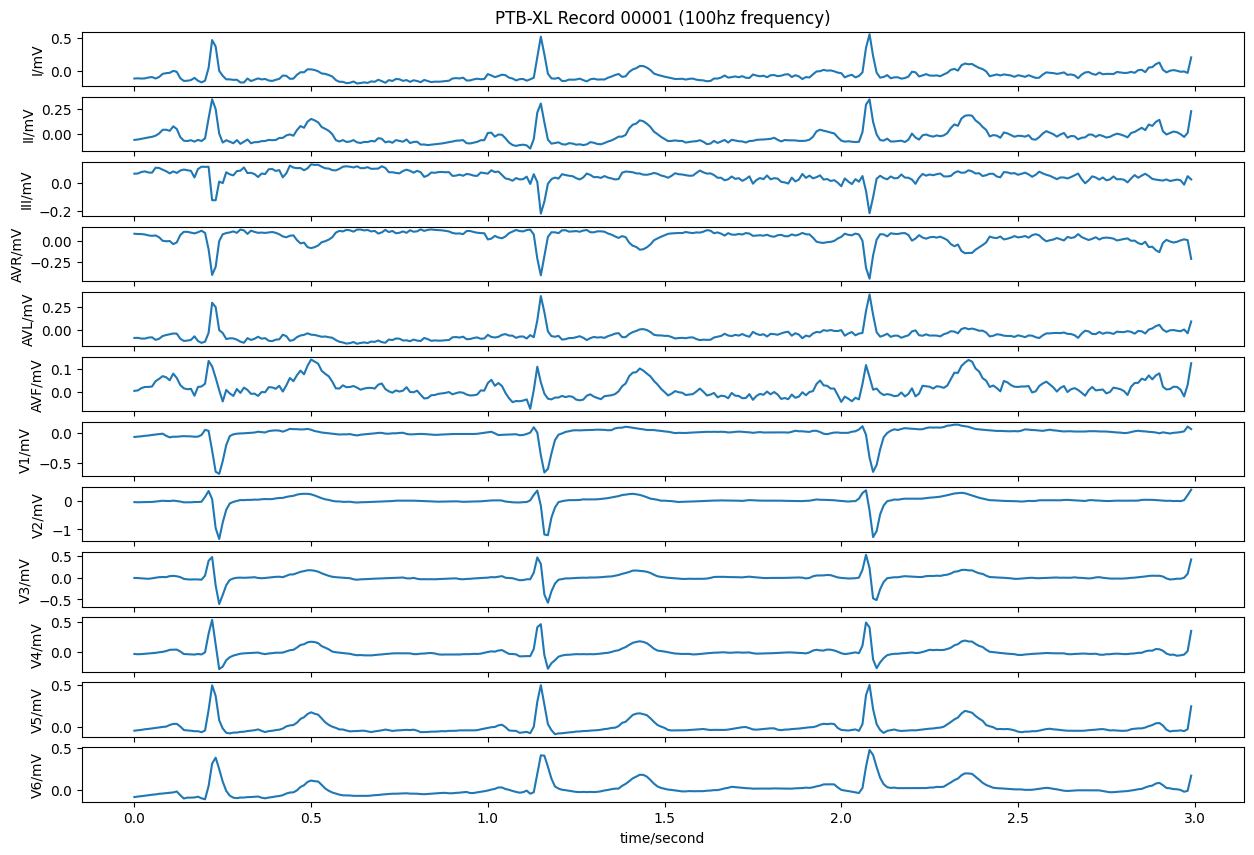

In [15]:
patient_path_100hz = "datasets/physionet.org/files/ptb-xl/1.0.3/records100/00000/00001_lr"
patient_record_ptb_100hz = wfdb.rdrecord(patient_path_100hz, sampto=300)
wfdb.plot_wfdb(patient_record_ptb_100hz, figsize=(15, 10), title='PTB-XL Record 00001 (100hz frequency)', time_units='seconds')

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
0


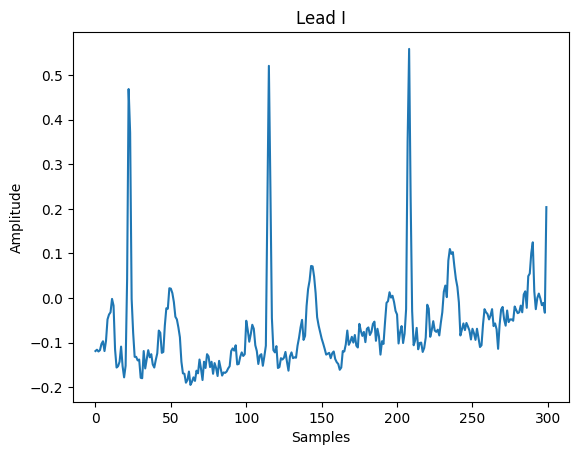

In [16]:
print(f"Leads available: {patient_record_ptb_100hz.sig_name}")
plot_signal_lead(record=patient_record_ptb_100hz, lead_name="I")

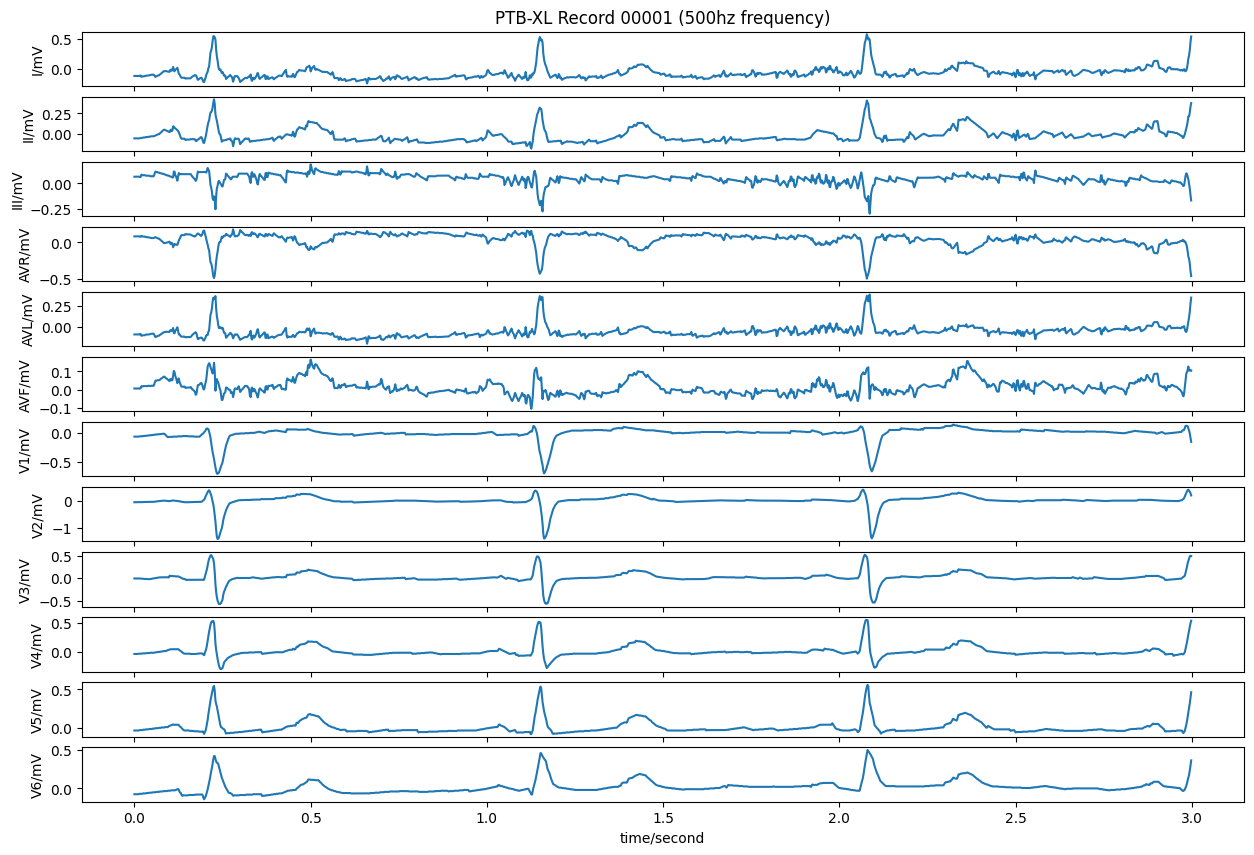

In [17]:
patient_path_500hz = "datasets/physionet.org/files/ptb-xl/1.0.3/records500/00000/00001_hr"
patient_record_ptb_500hz = wfdb.rdrecord(patient_path_500hz, sampto=1500)
wfdb.plot_wfdb(patient_record_ptb_500hz, figsize=(15, 10), title='PTB-XL Record 00001 (500hz frequency)', time_units='seconds')

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
0


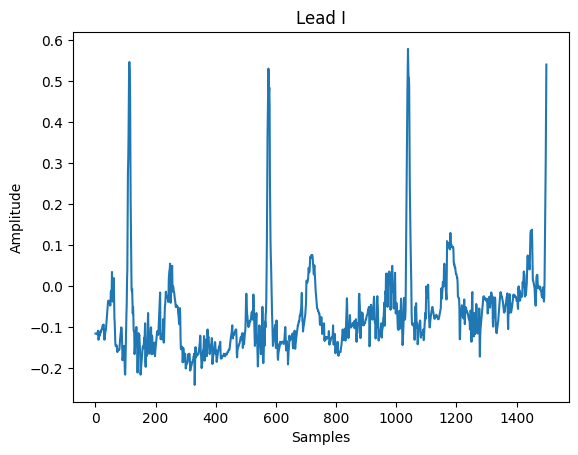

In [18]:
print(f"Leads available: {patient_record_ptb_500hz.sig_name}")
plot_signal_lead(record=patient_record_ptb_500hz, lead_name="I")

#### **SaMi-Trop Dataset**

len chagas_label: 815
247007
1631
[2]
Keys available: ['tracings']
(1631, 4096, 12)
(4096, 12)


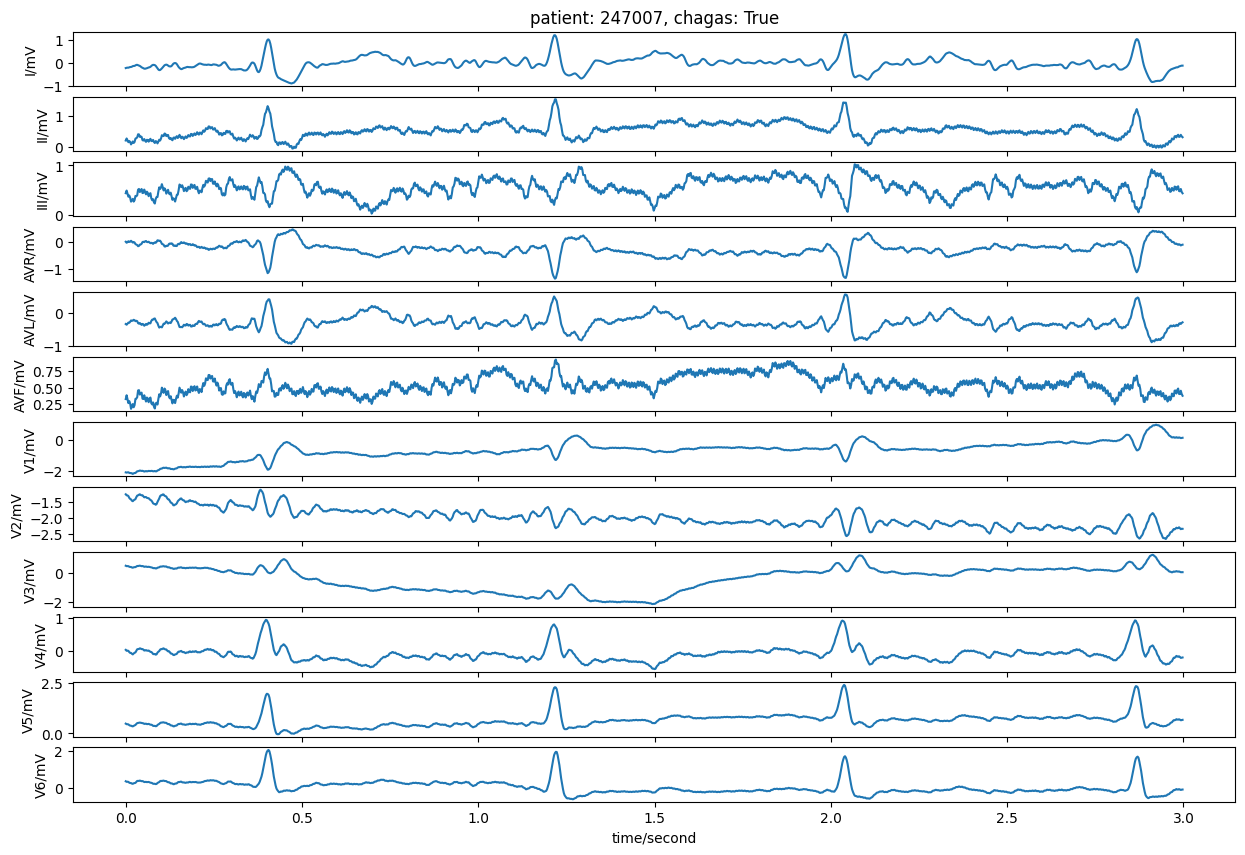

In [ ]:
# Path file SaMi-Trop dataset and labels
hdf5_file = "datasets/Sami-Trop/exams.hdf5"
hdf5_labels = "datasets/Sami-Trop/samitrop_chagas_labels.csv"

# Temporary name for WFDB file
temp_dir = tempfile.mkdtemp()
record_name = "test_record"

# Signal parameters
sampling_frequency = 400  # In Hz
lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
units = "mV"
gain = 1000
num_bits = 16

df_labels = pd.read_csv(hdf5_labels)
exam_id = df_labels.iloc[0, 0]
chagas = df_labels.iloc[0, 1] 
print(f"len chagas_label: {len(df_labels)}")
print(exam_id)

df_data = pd.read_csv("datasets/Sami-Trop/exams.csv")
idx = df_data.index[df_data['exam_id'] == exam_id].tolist()
print(len(df_data))
print(idx)

# Reads the first patient that has Chagas desease from the HDF5 file
with h5py.File(hdf5_file, "r") as f:
    print("Keys available:", list(f.keys()))
    print(f['tracings'].shape)
    physical_signals = np.squeeze(np.array(f['tracings'][idx], dtype=np.float32))  # First patient/record
    print(physical_signals.shape)
    num_samples, num_leads = physical_signals.shape
    assert num_leads == 12, "Number of leads is not 12"

# Convert signal to digital format for WFDB
# CHECK LATER
digital_signals = np.round(physical_signals * gain).astype(np.int16)
digital_signals = np.clip(digital_signals, -2**(num_bits-1)+1, 2**(num_bits-1)-1)

# Save in WFDB format
wfdb.wrsamp(
    record_name=record_name,
    fs=400,  # Sampling rate
    units=['mV'] * 12,  # Unit of measurement for each derivation
    sig_name=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],  # Derivative names (the order is correct)
    d_signal=digital_signals,  # Digital signal
    fmt=['16'] * 12,  # 16-bit format for each derivation
    adc_gain=[1000] * 12,  # Gain for each derivation
    baseline=[0] * 12  # Baseline for each derivation
)

# Plot the signal using wfdb.plot_wfdb()
record_sami = wfdb.rdrecord(f"test_record", sampto=1200)
wfdb.plot_wfdb(record_sami, figsize=(15, 10), title=f"patient: {exam_id}, chagas: {chagas}")
plt.show()

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
0


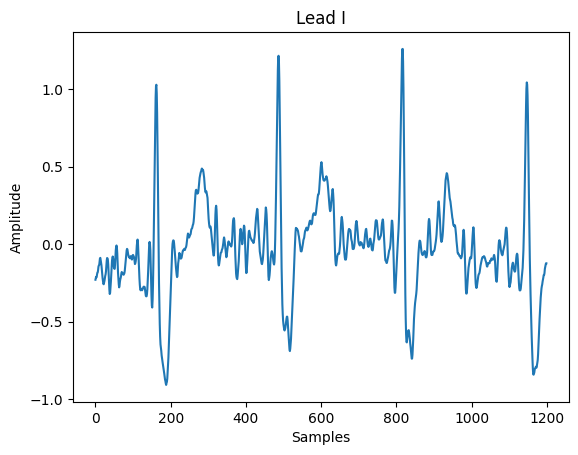

In [20]:
print(f"Leads available: {record_sami.sig_name}")
plot_signal_lead(record=record_sami, lead_name="I")

#### **Code-15% Dataset**

len chagas_label: 343424
exam_id: 418484
idx: [274426, 304020]
Keys available: ['exam_id', 'tracings']
(20001, 4096, 12)
exams_part7: [2867298  416736 1160836 ...  605304 1342756       0]
True
Index found: [2859]
Index found: 2859
Associated tracings: [[ -0.75458163  -0.9984868   -0.24390517 ... -15.968167    -0.20579499
   -1.7073362 ]
 [ -0.7416983   -0.98736054  -0.24566223 ... -15.993779    -0.19445887
   -1.6761489 ]
 [ -0.73513156  -0.9706356   -0.23550403 ... -15.936635    -0.1854795
   -1.6530582 ]
 ...
 [ -0.8768928   -1.2726284   -0.3957356  ...   0.9966566   -0.98401004
   -0.87747765]
 [ -0.8741664   -1.2706177   -0.39645132 ...   0.9962846   -0.9811447
   -0.87365764]
 [ -0.8770633   -1.2726268   -0.39556345 ...   0.9865607   -0.98260546
   -0.8778711 ]]
(4096, 12)


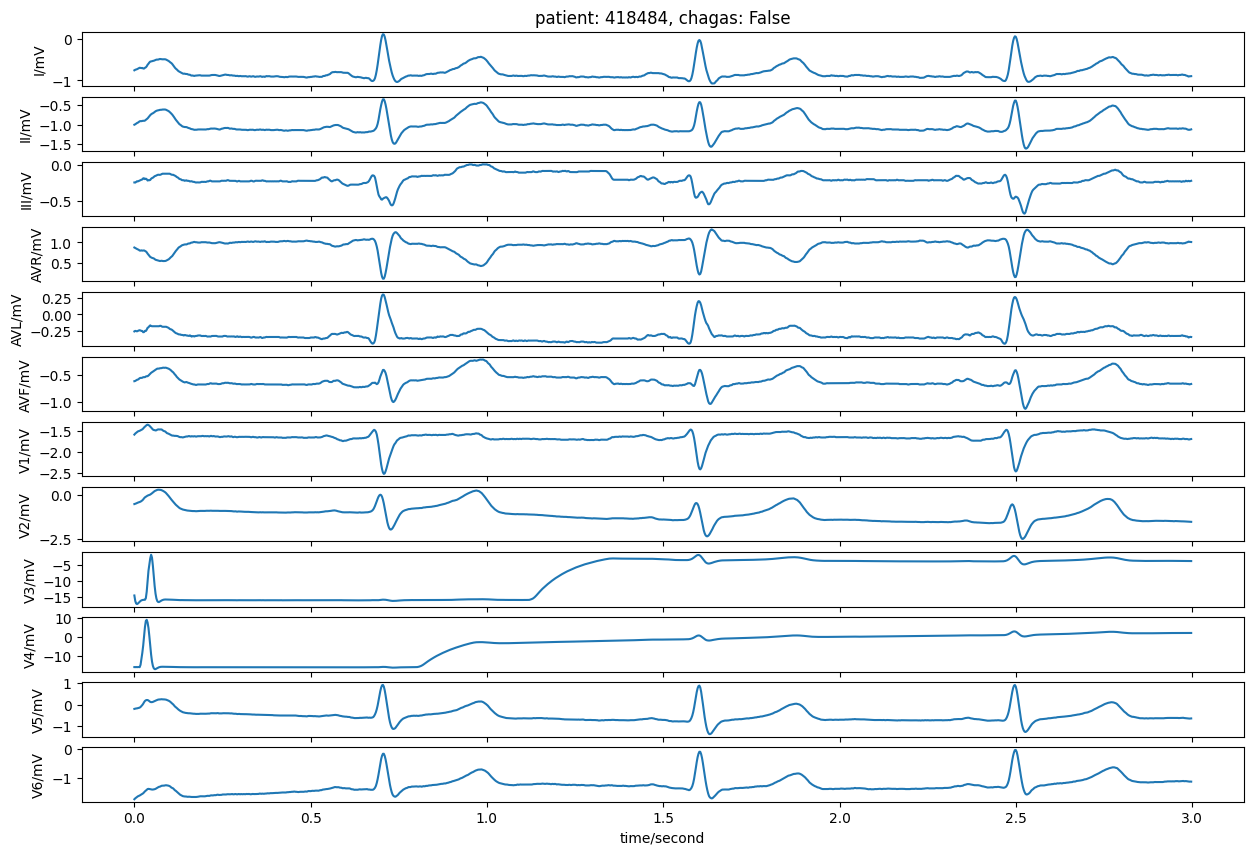

In [21]:
# Path file Code15% dataset and labels
hdf5_file = "datasets/code15/exams_part7.hdf5"
hdf5_labels = "datasets/code15/code15_chagas_labels.csv"

# Temporary name for WFDB file
temp_dir = tempfile.mkdtemp()
record_name = "test_record_code15"

# Signal parameters
sampling_frequency = 400  # In Hz
lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
units = "mV"
gain = 1000
num_bits = 16

df_labels = pd.read_csv(hdf5_labels)
exam_id = df_labels.iloc[0, 0]
patient_id = df_labels.iloc[0, 1] 
chagas = df_labels.iloc[0, 2] 
print(f"len chagas_label: {len(df_labels)}")

print(f"exam_id: {exam_id}")
df_data = pd.read_csv("datasets/code15/exams.csv")
idx = df_data.index[df_data['patient_id'] == patient_id].tolist()
print(f"idx: {idx}")

# Reads the first signal from the HDF5 file
with h5py.File(hdf5_file, "r") as f:
    print("Keys available:", list(f.keys()))
    print(f['tracings'].shape)
    data_test = f['exam_id'][:]
    print(f"exams_part7: {data_test}")
    print(f"{np.any(f['exam_id'][:] == exam_id)}")
    indices = np.where(f["exam_id"][:] == exam_id)[0]  # Find the location of the ID
    print(f"Index found: {indices}")
    if len(indices) > 0:
        idx = indices[0]  # Let's take the first match
        print(f"Index found: {idx}")
        print(f"Associated tracings: {f['tracings'][idx]}")
    else:
        print("ID not found in dataset!")
    physical_signals = np.squeeze(np.array(f['tracings'][idx], dtype=np.float32))  # First patient
    print(physical_signals.shape)
    num_samples, num_leads = physical_signals.shape
    assert num_leads == 12, "Number of leads is not 12"

# Convert signal to digital format for WFDB
digital_signals = np.round(physical_signals * gain).astype(np.int16)
digital_signals = np.clip(digital_signals, -2**(num_bits-1)+1, 2**(num_bits-1)-1)

# Save in WFDB format
wfdb.wrsamp(
    record_name=record_name,
    fs=400,  # Sampling rate
    units=['mV'] * 12,  # Unit of measurement for each derivation
    sig_name=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],  # Nomi delle derivazioni
    d_signal=digital_signals,  # Digital signal
    fmt=['16'] * 12,  # 16-bit format for each derivation
    adc_gain=[1000] * 12,  # Gain for each derivation
    baseline=[0] * 12  # Baseline for each derivation
)

# Plot the signal using wfdb.plot_wfdb()
record_code = wfdb.rdrecord(f"test_record_code15", sampto=1200)
wfdb.plot_wfdb(record_code, figsize=(15, 10), title=f"patient: {exam_id}, chagas: {chagas}")
plt.show()

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
0


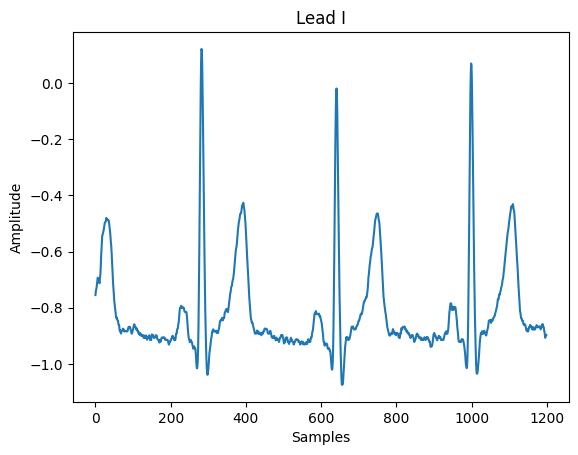

In [22]:
print(f"Leads available: {record_code.sig_name}")
plot_signal_lead(record=record_code, lead_name="I")

### **Preprocessing stage**

In [2]:
# Function to apply bandpass filter
def bandpass_filter(signal_data: np.ndarray, low_cutoff: float = 0.5, high_cutoff: float = 150, fs: int = 400, order=3):
    # Butterworth band pass filter's parameters
    nyquist = 0.5 * fs  # Nyquist frequency
    low = low_cutoff / nyquist  # Normalized low cutoff frequency
    high = high_cutoff / nyquist  # Normalized high cutoff frequency
    
    # Create Butterworth band pass filter
    b, a = sp.signal.butter(order, [low, high], btype='band')
    
    # Apply filter to signal
    filtered_signal = sp.signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [3]:
def get_frequency_spectrum(signal: np.ndarray, freq_to: float = 0, freq_from: float = 1000, fs: int = 400):
  """
  Computes the frequency spectrum of a given signal using the Fast Fourier Transform (FFT)
    and returns the amplitude of frequency components within a specified range.

    Parameters:
    - signal (array-like): the input signal to be analyzed.
    - freq_to (float): the lower bound of the frequency range to consider (in Hz).
    - freq_from (float): the upper bound of the frequency range to consider (in Hz).

    Returns:
    - filtered_frequencies (array-like): the frequencies within the specified range.
    - filtered_fft_data (array-like): the corresponding amplitude of the frequency components.
  """

  # Calculate FFT of the signal
  fft_data = np.fft.fft(signal)  # Select the first lead
  frequencies = np.fft.fftfreq(len(signal), d=1/fs)

  # Find the indices corresponding to the positive frequencies
  positive_frequencies = frequencies[:len(frequencies)//2]
  positive_fft_data = np.abs(fft_data[:len(fft_data)//2])

  # Filter for frequencies between the input range
  freq_range = (positive_frequencies >= freq_to) & (positive_frequencies <= freq_from)
  filtered_frequencies = positive_frequencies[freq_range]
  filtered_fft_data = positive_fft_data[freq_range]
  return filtered_frequencies, filtered_fft_data

In [4]:
def notch_filter(signal: np.ndarray, notch_frequency: float = 60, quality_factor: int = 30, sampling_rate: int = 400):
  """
  Applies a notch filter to remove a specific frequency from the input signal.

  Parameters:
  - signal (array-like): the input signal to be filtered
  - notch_frequency (float, optional): the target frequency to be removed, in Hz (default 60 Hz)
  - quality_factor (float, optional): the quality factor of the notch filter, which determines
    the filter's bandwidth (default 30).
  - sampling_rate (float, optional): the sampling rate of the signal in Hz (default 360 Hz)

  Returns:
  - filtered_signal (array-like): the filtered signal after removing the specified frequency.
  """
  # Calculate the notch filter coefficients
  b, a = sp.signal.iirnotch(notch_frequency / (sampling_rate / 2), quality_factor)

  # Filters the signal to remove 60Hz interference
  return sp.signal.filtfilt(b, a, signal)

In [5]:
def anti_aliasing_filter(signal: np.ndarray, fs_original: int = 500, fs_target: int = 400):
    nyquist_target = fs_target / 2  # Nyquist of the new frequency (200 Hz)
    # Creating the low-pass filter
    b, a = sp.signal.butter(N=8, Wn=nyquist_target / (fs_original / 2), btype='low')
    # Applicazione del filtro
    signal_filtered = sp.signal.filtfilt(b, a, signal)
    
    return signal_filtered

In [6]:
def normalize_ecg(signal: np.ndarray, scaler: MinMaxScaler):
    return scaler.fit_transform(np.array(signal).reshape(-1, 1)).reshape(-1)

#### **PTB-XL Preprocessing**

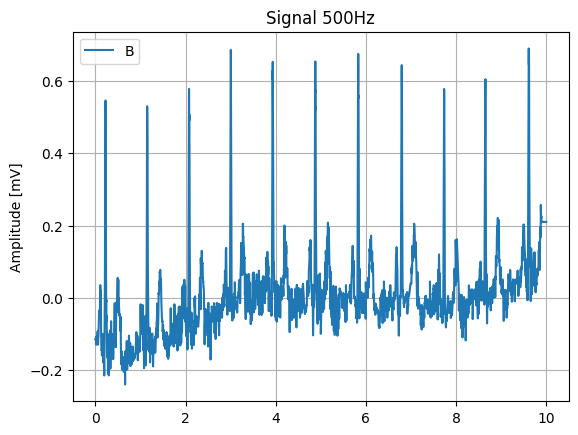

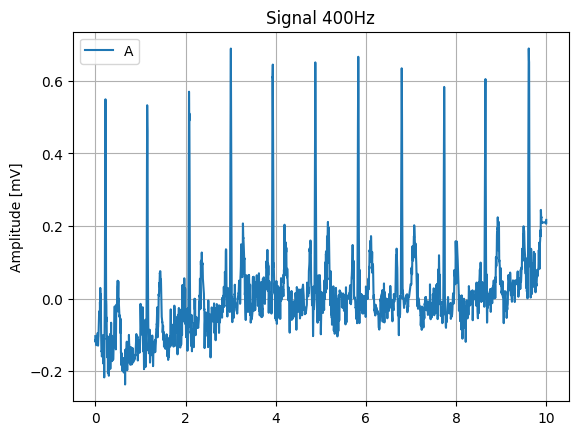

In [28]:
patient_record_ptb_500hz = wfdb.rdrecord(patient_path_500hz)
t = np.arange(len(patient_record_ptb_500hz.p_signal[:, 0][:5000])) / 500  # Creating the time axis
plt.plot(t, patient_record_ptb_500hz.p_signal[:, 0])
plt.ylabel("Amplitude [mV]")
plt.legend("Before")
plt.grid(True)
plt.title("Signal 500Hz")
plt.show()

signal_antialiased = anti_aliasing_filter(patient_record_ptb_500hz.p_signal[:, 0])
signal_downsampled = sp.signal.resample_poly(signal_antialiased, up=4, down=5)
t = np.arange(len(signal_downsampled[:5000])) / 400  # Creating the time axis
plt.plot(t, signal_downsampled)
plt.ylabel("Amplitude [mV]")
plt.legend("After")
plt.grid(True)
plt.title("Signal 400Hz")
plt.show()

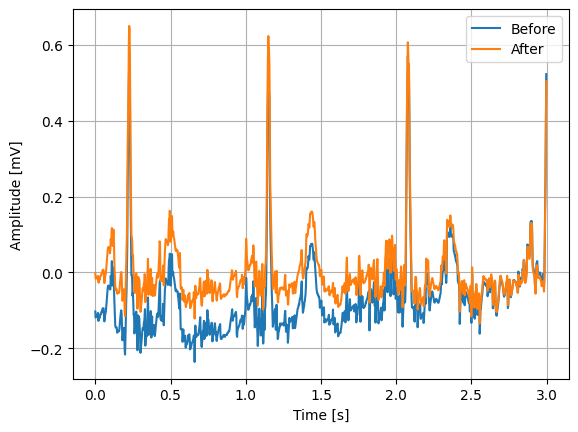

Average amplitude of the original signal: 0.0026094226204125305
Average amplitude of the filtered signal: 0.0003357442452733026


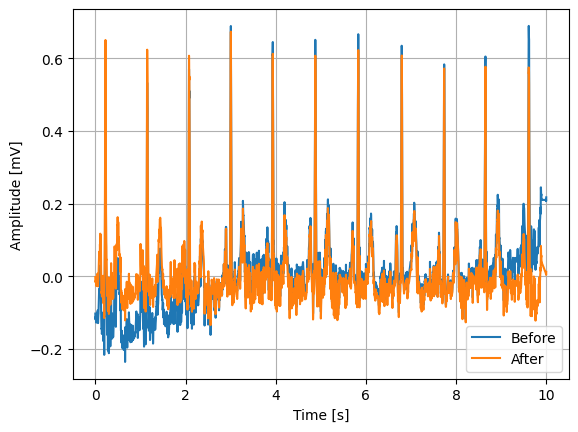

In [29]:
# Applying bandpass filter
filtered_band_pass_signal = bandpass_filter(signal_downsampled)
t = np.arange(len(filtered_band_pass_signal[:1200])) / 400  # Creating the time axis
plt.plot(t, signal_downsampled[:1200])
plt.plot(t, filtered_band_pass_signal[:1200])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()
print(f"Average amplitude of the original signal: {signal_antialiased.mean()}")
print(f"Average amplitude of the filtered signal: {filtered_band_pass_signal.mean()}")

t = np.arange(len(filtered_band_pass_signal[:5000])) / 400  # Creating the time axis
plt.plot(t, signal_downsampled[:5000])
plt.plot(t, filtered_band_pass_signal[:5000])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

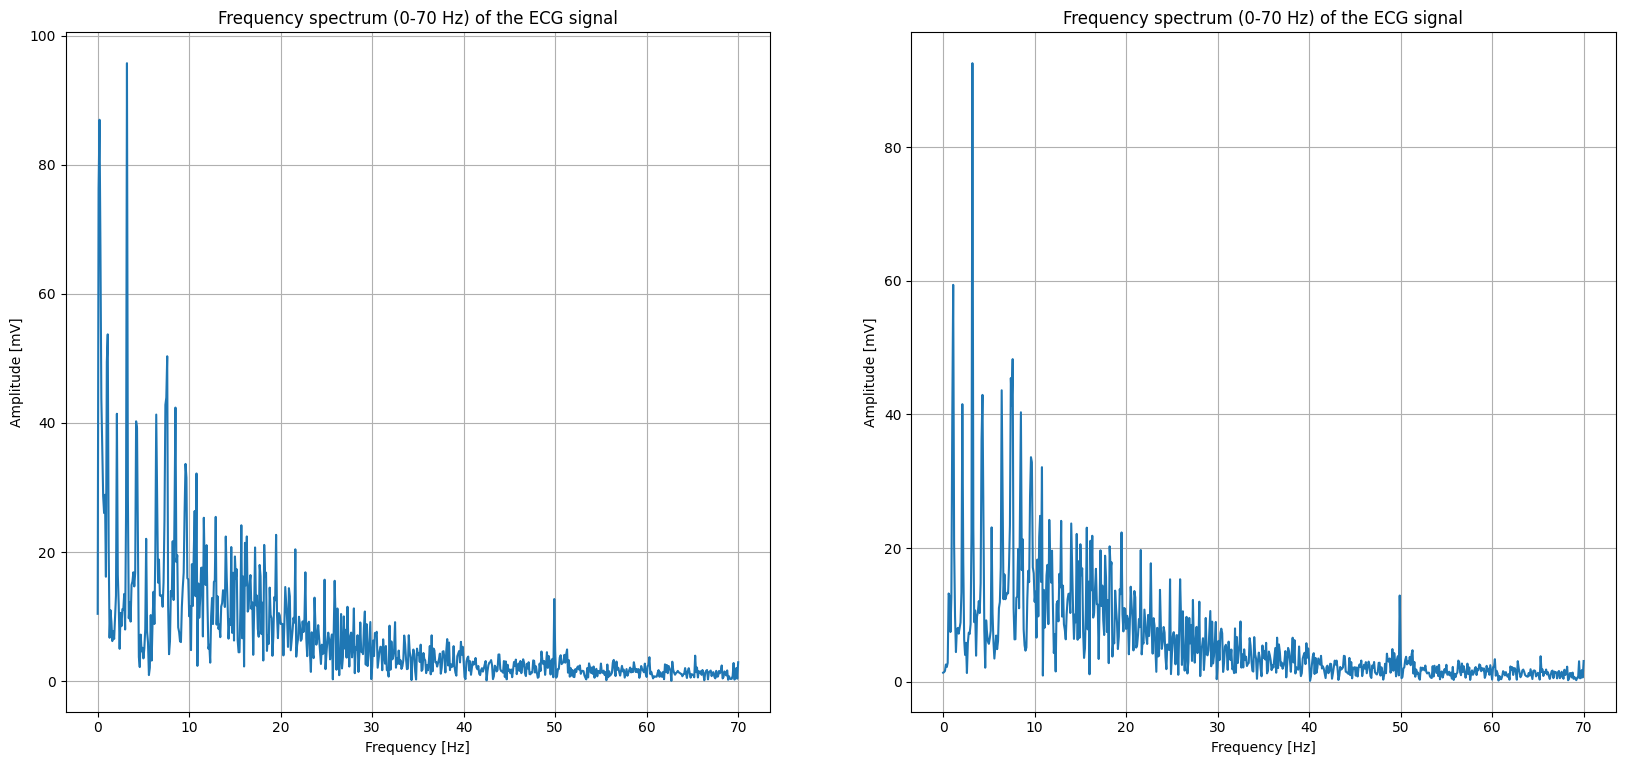

In [30]:
plt.figure(figsize=(20, 30))
filtered_frequencies_old, filtered_fft_data_old = get_frequency_spectrum(signal_downsampled, 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.subplot(3, 2, 1)
plt.plot(filtered_frequencies_old, filtered_fft_data_old)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)

filtered_frequencies_new, filtered_fft_data_new = get_frequency_spectrum(filtered_band_pass_signal, 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.subplot(3, 2, 2)
plt.plot(filtered_frequencies_new, filtered_fft_data_new)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.show()

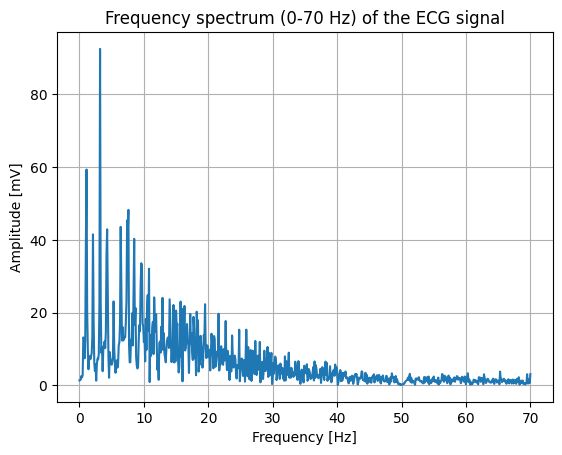

In [31]:
signal_notch_filtered = notch_filter(signal=filtered_band_pass_signal, notch_frequency=50)
filtered_frequencies_new, filtered_fft_data_new = get_frequency_spectrum(signal_notch_filtered, 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.plot(filtered_frequencies_new, filtered_fft_data_new)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.show()

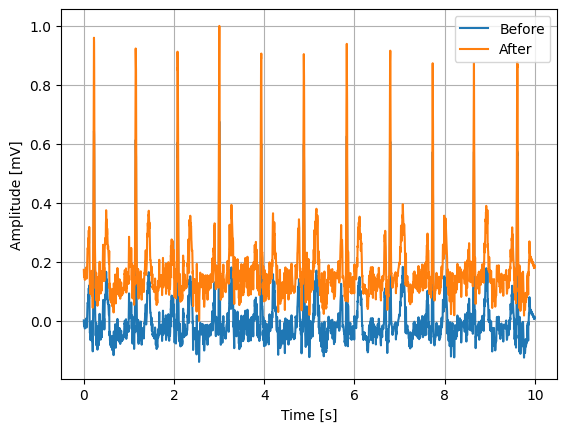

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
ptb_signal_cleaned = normalize_ecg(signal_notch_filtered, scaler)
t = np.arange(len(ptb_signal_cleaned)) / 400  # Creating the time axis
plt.plot(t, signal_notch_filtered)
plt.plot(t, ptb_signal_cleaned)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

#### **SaMi-Trop Preprocessing**

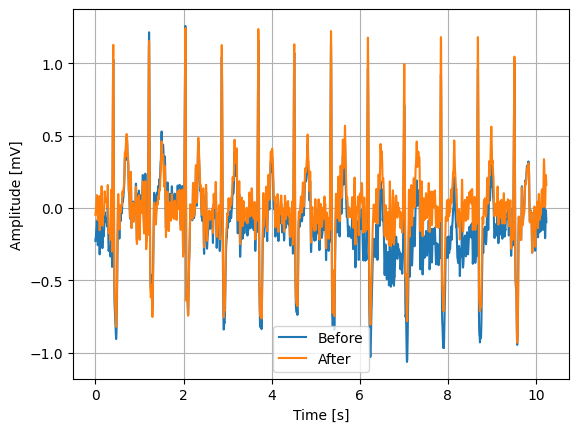

Average amplitude of the original signal: -0.112572509765625
Average amplitude of the filtered signal: -0.0008273231052209554


In [24]:
record_sami_f = wfdb.rdrecord(f"test_record")
# Applying bandpass filter
t = np.arange(len(record_sami_f.p_signal[:,0][:len(record_sami_f.p_signal[:,0])])) / 400  # Creating the time axis
filtered_band_pass_signal = bandpass_filter(record_sami_f.p_signal[:,0])
plt.plot(t, record_sami_f.p_signal[:,0][:len(record_sami_f.p_signal[:,0])])
plt.plot(t, filtered_band_pass_signal[:len(record_sami_f.p_signal[:,0])])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()
print(f"Average amplitude of the original signal: {record_sami_f.p_signal[:,0].mean()}")
print(f"Average amplitude of the filtered signal: {filtered_band_pass_signal.mean()}")

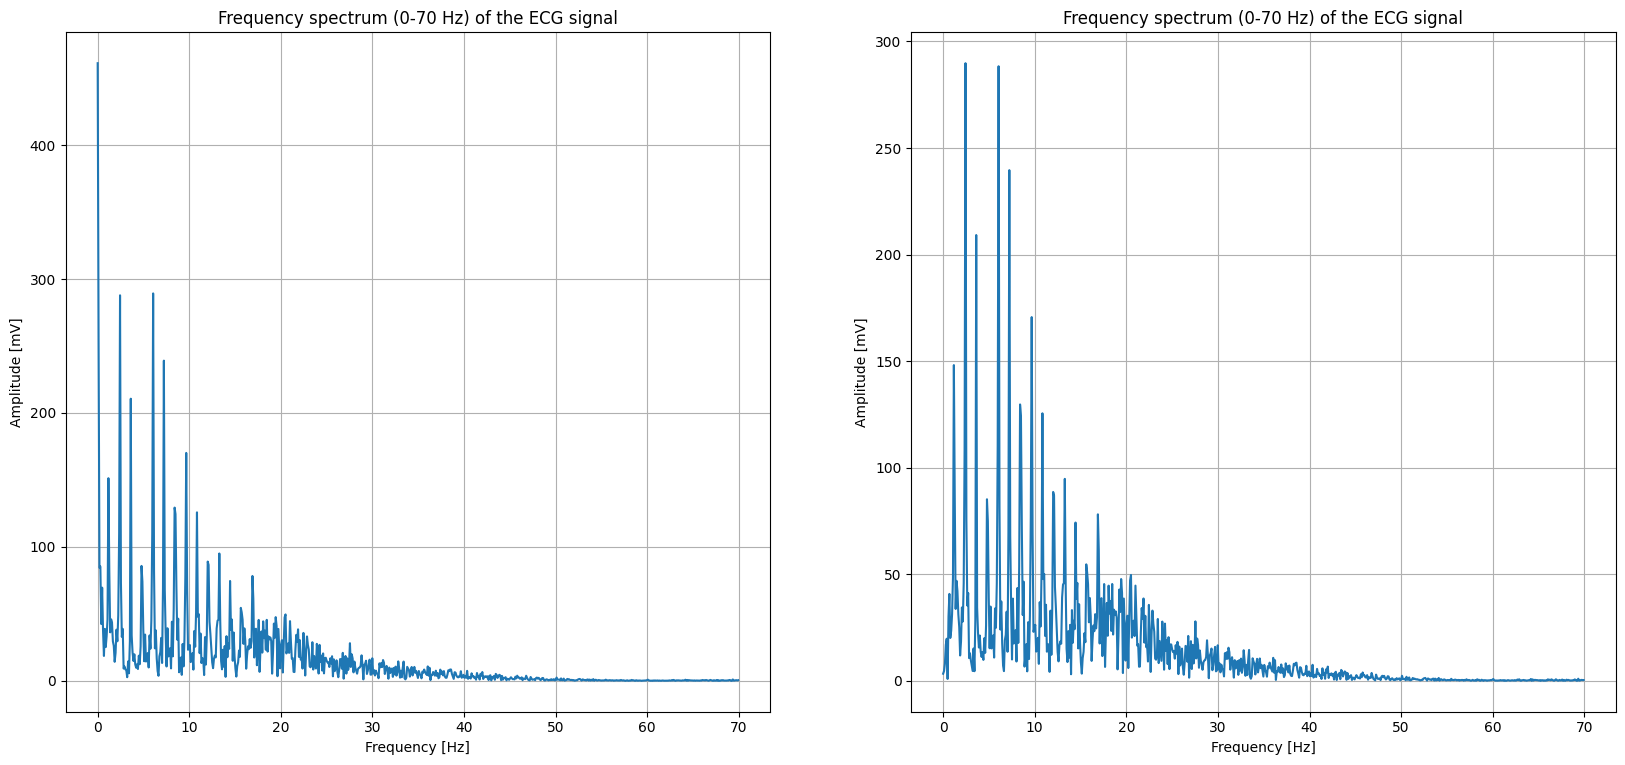

In [25]:
plt.figure(figsize=(20, 30))
filtered_frequencies_old, filtered_fft_data_old = get_frequency_spectrum(record_sami_f.p_signal[:,0], 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.subplot(3, 2, 1)
plt.plot(filtered_frequencies_old, filtered_fft_data_old)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)

filtered_frequencies_new, filtered_fft_data_new = get_frequency_spectrum(filtered_band_pass_signal, 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.subplot(3, 2, 2)
plt.plot(filtered_frequencies_new, filtered_fft_data_new)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.show()

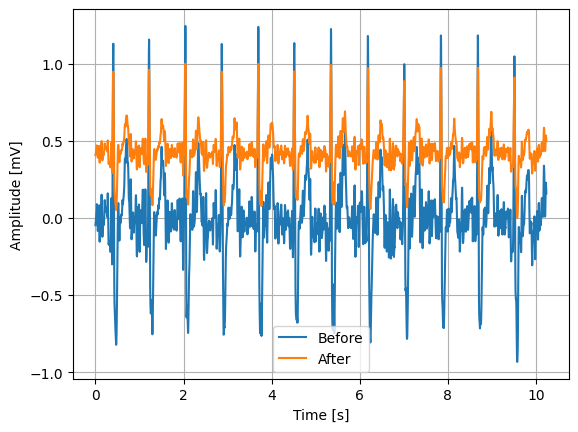

Average amplitude of the filtered signal: 0.42833178116367554
0.40682234109995347


In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))
sami_signal_cleaned = normalize_ecg(filtered_band_pass_signal, scaler)
t = np.arange(len(sami_signal_cleaned)) / 400  # Creating the time axis
plt.plot(t, filtered_band_pass_signal)
plt.plot(t, sami_signal_cleaned)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

print(f"Average amplitude of the filtered signal: {sami_signal_cleaned.mean()}")
print(sami_signal_cleaned[0])

#### **Code-15% Preprocessing**

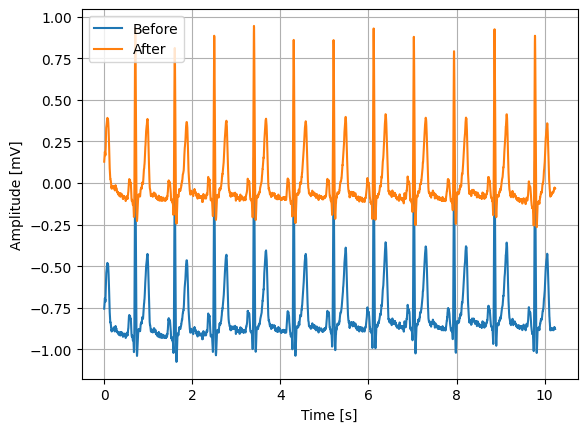

Average amplitude of the original signal: -0.79127978515625
Average amplitude of the filtered signal: 0.0020813984269491183


In [36]:
record_code_f = wfdb.rdrecord(f"test_record_code15")
# Applying bandpass filter
t = np.arange(len(record_code_f.p_signal[:,0][:len(record_code_f.p_signal[:,0])])) / 400  # Creating the time axis
filtered_band_pass_signal = bandpass_filter(record_code_f.p_signal[:,0])
plt.plot(t, record_code_f.p_signal[:,0][:len(record_code_f.p_signal[:,0])])
plt.plot(t, filtered_band_pass_signal[:len(record_code_f.p_signal[:,0])])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()
print(f"Average amplitude of the original signal: {record_code_f.p_signal[:,0].mean()}")
print(f"Average amplitude of the filtered signal: {filtered_band_pass_signal.mean()}")

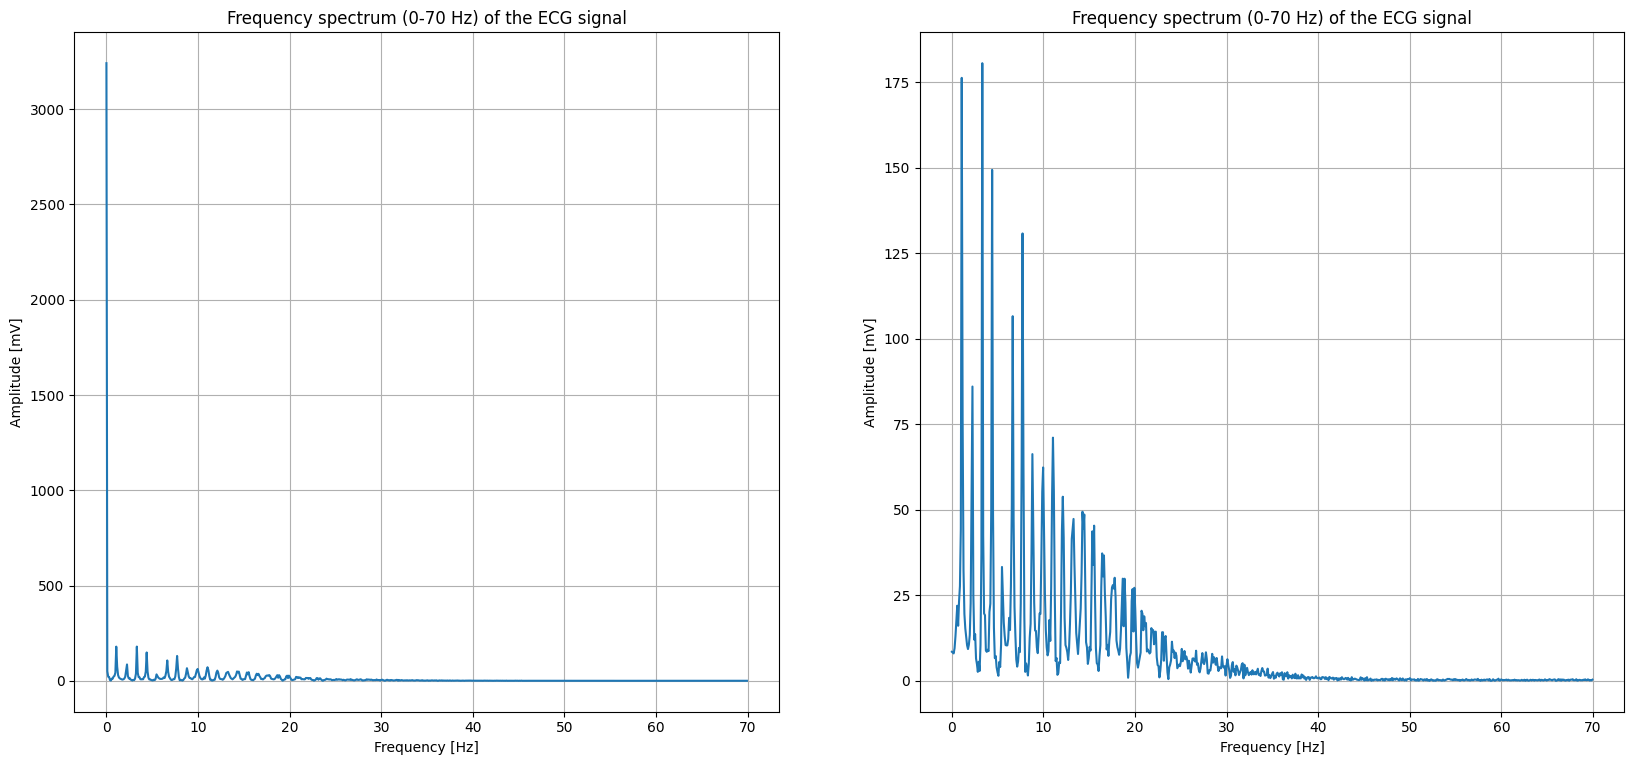

In [37]:
plt.figure(figsize=(20, 30))
filtered_frequencies_old, filtered_fft_data_old = get_frequency_spectrum(record_code_f.p_signal[:,0], 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.subplot(3, 2, 1)
plt.plot(filtered_frequencies_old, filtered_fft_data_old)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)

filtered_frequencies_new, filtered_fft_data_new = get_frequency_spectrum(filtered_band_pass_signal, 0, 70)
# Displays the frequency spectrum between 0 and 70 Hz
plt.subplot(3, 2, 2)
plt.plot(filtered_frequencies_new, filtered_fft_data_new)
plt.title("Frequency spectrum (0-70 Hz) of the ECG signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.show()

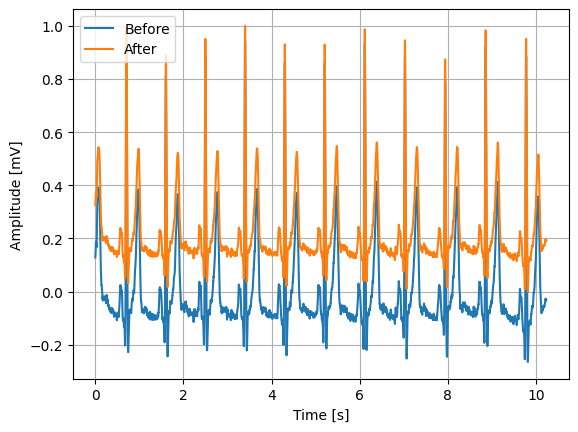

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
code_signal_cleaned = normalize_ecg(filtered_band_pass_signal, scaler)
t = np.arange(len(code_signal_cleaned)) / 400  # Creating the time axis
plt.plot(t, filtered_band_pass_signal)
plt.plot(t, code_signal_cleaned)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [mV]")
plt.grid(True)
plt.legend(("Before", "After"))
plt.show()

#### **Create new preprocessed datasets**

In [7]:
def preprocessing_ptb_xl(signal: np.ndarray, scaler: MinMaxScaler):
    signal_antialiased = anti_aliasing_filter(signal)
    signal_downsampled = sp.signal.resample_poly(signal_antialiased, up=4, down=5)
    filtered_band_pass_signal = bandpass_filter(signal_downsampled)
    signal_notch_filtered = notch_filter(signal=filtered_band_pass_signal, notch_frequency=50)
    signal_cleaned = normalize_ecg(signal_notch_filtered, scaler)

    return signal_cleaned

In [8]:
def preprocessing_sami_trop_and_code(signal: np.ndarray, scaler: MinMaxScaler):
    filtered_band_pass_signal = bandpass_filter(signal)
    signal_cleaned = normalize_ecg(filtered_band_pass_signal, scaler)

    return signal_cleaned

In [9]:
def plot_signal(signal: np.ndarray, chagas, patient_id):
    t = np.arange(len(signal)) / 400  # Creating the time axis
    plt.figsize=(15, 10)
    plt.plot(t, signal)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(f"Patient: {patient_id}, chagas: {chagas}")
    plt.grid(True)
    plt.show()

##### **PTB-XL preprocessed dataset**

In [ ]:
# Loading in 11 minutes
dataset_path = Path("datasets/physionet.org/files/ptb-xl/1.0.3/records500")
dataset_ptb_xl = []
print(f"Start loading...")
head_files = list(dataset_path.rglob("*.hea"))
file_names = sorted([str(f.with_suffix("")) for f in dataset_path.rglob("*.hea")])
scaler = MinMaxScaler(feature_range=(0, 1))
print(f"len file_names: {len(file_names)}")
for file_name in file_names:
    patient_record = wfdb.rdrecord(f"{file_name}")
    # Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    patient_entry = {
        "patient_id": Path(file_name).stem,
        "lead_I": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("I")], scaler),
        "lead_II": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("II")], scaler),
        "lead_III": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("III")], scaler),
        "lead_AVR": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("AVR")], scaler),
        "lead_AVL": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("AVL")], scaler),
        "lead_AVF": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("AVF")], scaler),
        "lead_V1": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("V1")], scaler),
        "lead_V2": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("V2")], scaler),
        "lead_V3": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("V3")], scaler),
        "lead_V4": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("V4")], scaler),
        "lead_V5": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("V5")], scaler),
        "lead_V6": preprocessing_ptb_xl(patient_record.p_signal[:, patient_record.sig_name.index("V6")], scaler),
        "chagas": False,
    }
    dataset_ptb_xl.append(patient_entry)

with open("datasets/ptb_xl.pkl", "wb") as f:
    pickle.dump(dataset_ptb_xl, f)
print(f"Loading complete!")

Start loading...


len file_names: 21799
Loading complete!


In [ ]:
# Retrieve in 43 seconds
with open("datasets/ptb_xl.pkl", "rb") as f:
    dataset_loaded_ptb_xl = pickle.load(f)

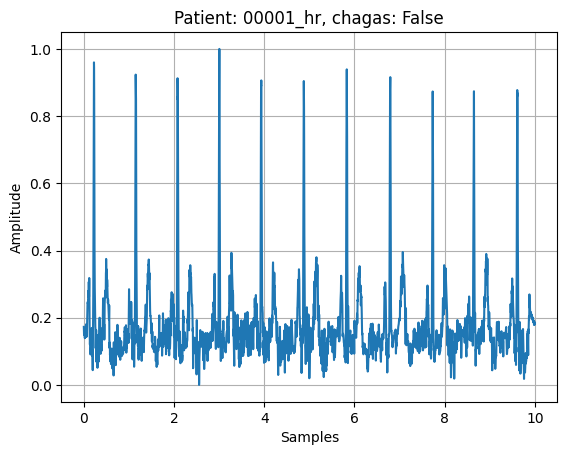

In [46]:
plot_signal(dataset_loaded_ptb_xl[0].get("lead_I"), dataset_loaded_ptb_xl[0].get("chagas"), dataset_loaded_ptb_xl[0].get("patient_id"))

##### **SaMi-Trop preprocessed dataset**

In [44]:
# Loading in 1 minute
# Path file SaMi-Trop dataset and labels
hdf5_file = "datasets/Sami-Trop/exams.hdf5"
hdf5_labels = "datasets/Sami-Trop/samitrop_chagas_labels.csv"

# Temporary name for WFDB file
record_name = "temp_test_record_sami"

# Signal parameters
sampling_frequency = 400  # In Hz
lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
units = "mV"
gain = 1000
num_bits = 16

df_labels = pd.read_csv(hdf5_labels)
exam_id = df_labels.iloc[0, 0]
chagas = df_labels.iloc[0, 1] 

df_data = pd.read_csv("datasets/Sami-Trop/exams.csv")
ids = df_data.iloc[:, 0].tolist()

dataset_sami_trop = []
print(f"Start loading...")
scaler = MinMaxScaler(feature_range=(0, 1))
# Reads the first patient that has Chagas desease from the HDF5 file
with h5py.File(hdf5_file, "r") as f:
    num_records = f['tracings'].shape[0]
    for idx, id in zip(range(num_records), ids):
        physical_signals = np.squeeze(np.array(f['tracings'][idx], dtype=np.float32))  # First patient/record
        #print(physical_signals.shape)
        num_samples, num_leads = physical_signals.shape
        assert num_leads == 12, "Number of leads is not 12"
        chagas = id in df_labels["exam_id"].values

        # Convert signal to digital format for WFDB
        # CHECK LATER
        digital_signals = np.round(physical_signals * gain).astype(np.int16)
        digital_signals = np.clip(digital_signals, -2**(num_bits-1)+1, 2**(num_bits-1)-1)

        # Save in WFDB format
        wfdb.wrsamp(
            record_name=record_name,
            fs=400,  # Sampling rate
            units=['mV'] * 12,  # Unit of measurement for each derivation
            sig_name=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],  # Derivative names (the order is correct)
            d_signal=digital_signals,  # Digital signal
            fmt=['16'] * 12,  # 16-bit format for each derivation
            adc_gain=[1000] * 12,  # Gain for each derivation
            baseline=[0] * 12  # Baseline for each derivation
        )

        #record_sami = wfdb.rdrecord(f"temp_test_record_sami")

        patient_record = wfdb.rdrecord(record_name)
        # Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        patient_entry = {
            "patient_id": id,
            "lead_I": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("I")], scaler),
            "lead_II": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("II")], scaler),
            "lead_III": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("III")], scaler),
            "lead_AVR": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("AVR")], scaler),
            "lead_AVL": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("AVL")], scaler),
            "lead_AVF": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("AVF")], scaler),
            "lead_V1": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V1")], scaler),
            "lead_V2": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V2")], scaler),
            "lead_V3": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V3")], scaler),
            "lead_V4": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V4")], scaler),
            "lead_V5": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V5")], scaler),
            "lead_V6": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V6")], scaler),
            "chagas": chagas,
        }
        dataset_sami_trop.append(patient_entry)

with open("datasets/sami_trop.pkl", "wb") as f:
    pickle.dump(dataset_sami_trop, f)
print(f"Loading complete!")

Start loading...


Loading complete!


In [45]:
with open("datasets/sami_trop.pkl", "rb") as f:
    dataset_loaded_sami_trop = pickle.load(f)

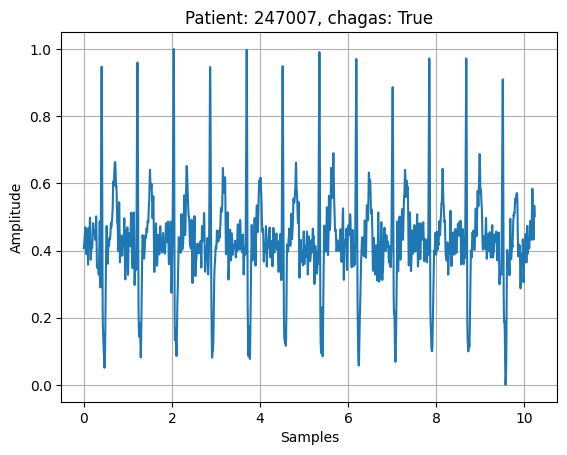

Average amplitude of the signal: 0.42833178116367554
0.40682234109995347


In [47]:
# patient 247007 (chagas: True)
plot_signal(dataset_loaded_sami_trop[2].get("lead_I"), dataset_loaded_sami_trop[2].get("chagas"), dataset_loaded_sami_trop[2].get("patient_id"))
signal_mean_amplitude = dataset_loaded_sami_trop[2].get("lead_I").mean()
print(f"Average amplitude of the signal: {signal_mean_amplitude}")
print(dataset_loaded_sami_trop[2].get("lead_I")[0])

##### **Code-15% preprocessed dataset**

In [ ]:
# Path file Code15% dataset and labels
hdf5_file = "datasets/code15"
hdf5_labels = "datasets/code15/code15_chagas_labels.csv"

# Temporary name for WFDB file
record_name = "temp_test_record_code15"

# Signal parameters
sampling_frequency = 400  # In Hz
lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
units = "mV"
gain = 1000
num_bits = 16

df_labels = pd.read_csv(hdf5_labels)
print(f"len: {len(df_labels)}")
exam_id = df_labels.iloc[0, 0]
patient_id = df_labels.iloc[0, 1] 
chagas = df_labels.iloc[0, 2] 

df_data = pd.read_csv("datasets/code15/exams.csv")
ids = df_data.iloc[:, 0].tolist()
print(f"len: {len(ids)}")

dataset_code15 = []
print(f"Start loading...")
scaler = MinMaxScaler(feature_range=(0, 1))

exam_ids = df_labels.iloc[:, 0].tolist()
print(f"start for loop")
for _, line in tqdm(df_data.iterrows(), total=len(df_data)):
    chagas = None
    with h5py.File(f"{hdf5_file}/{line['trace_file']}", "r") as f:
        data_test = f['exam_id'][:]
        indices = np.where(f["exam_id"][:] == line['exam_id'])[0]  # Find the location of the ID
        if len(indices) > 0:
            idx = indices[0]  # Let's take the first match
        else:
            print("ID not found in dataset!")
        physical_signals = np.squeeze(np.array(f['tracings'][idx], dtype=np.float32))
        num_samples, num_leads = physical_signals.shape
        assert num_leads == 12, "Number of leads is not 12"

        # Convert signal to digital format for WFDB
        digital_signals = np.round(physical_signals * gain).astype(np.int16)
        digital_signals = np.clip(digital_signals, -2**(num_bits-1)+1, 2**(num_bits-1)-1)

        if line["exam_id"] in exam_ids:
            chagas = df_labels[df_labels['exam_id'] == line['exam_id']].iloc[0, 2]
        
        # Save in WFDB format
        wfdb.wrsamp(
            record_name=record_name,
            fs=400,  # Sampling rate
            units=['mV'] * 12,  # Unit of measurement for each derivation
            sig_name=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],  # Nomi delle derivazioni
            d_signal=digital_signals,  # Digital signal
            fmt=['16'] * 12,  # 16-bit format for each derivation
            adc_gain=[1000] * 12,  # Gain for each derivation
            baseline=[0] * 12  # Baseline for each derivation
        )

        patient_record = wfdb.rdrecord(record_name)
        # Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        patient_entry = {
            "patient_id": line['exam_id'], # It should be exam_id, correct later
            "lead_I": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("I")], scaler),
            "lead_II": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("II")], scaler),
            "lead_III": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("III")], scaler),
            "lead_AVR": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("AVR")], scaler),
            "lead_AVL": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("AVL")], scaler),
            "lead_AVF": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("AVF")], scaler),
            "lead_V1": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V1")], scaler),
            "lead_V2": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V2")], scaler),
            "lead_V3": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V3")], scaler),
            "lead_V4": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V4")], scaler),
            "lead_V5": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V5")], scaler),
            "lead_V6": preprocessing_sami_trop_and_code(patient_record.p_signal[:, patient_record.sig_name.index("V6")], scaler),
            "chagas": chagas,
        }
        dataset_code15.append(patient_entry)

with open("datasets/code15.pkl", "wb") as f:
    pickle.dump(dataset_code15, f)
print(f"Loading complete!")

len: 343424
len: 345779
Start loading...
start for loop


### **Segmentation stage**

### **Classification stage**

### **Evaluation stage**

### **Conclusions**